## In this project, we'll develop a predictive model to forecast device failures. By analyzing historical data on past failures and various device attributes, we can identify patterns and relationships that signal an increased risk of future breakdowns

## Importing Libraries

In [ ]:
!pip install tensorflow

In [ ]:
# pip install --upgrade tensorflow


In [ ]:
!pip install keras

In [ ]:
import pandas as pd
import numpy as np

import sklearn
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
# from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns

# from helper_pkg import Helper
# hlp = Helper()

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Properties

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

path = ''
file = 'failures_prediction.csv'
target_col = 'failure'




## Read Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


df = pd.read_csv('/content/drive/My Drive/failures_prediction.csv')
# hlp.analyse_df(df)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,1/1/2015,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,1/1/2015,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/2015,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/2015,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/2015,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [ ]:
attr_cols = [col for col in df.columns if 'attr' in col]
attr_cols

['attribute1',
 'attribute2',
 'attribute3',
 'attribute4',
 'attribute5',
 'attribute6',
 'attribute7',
 'attribute8',
 'attribute9']

## Helper Functions

In [ ]:
def scale_please(x, scaler):
    global attr_cols
    attr_cols = [col for col in x.columns if 'attrib' in col]
#     print(attr_cols)
    rest = [col for col in x.columns if col not in attr_cols]

    display(x[attr_cols].describe())
    x_scaled = pd.DataFrame(scaler.fit_transform(x[attr_cols]), columns=attr_cols)
    x_scaled = pd.concat([x_scaled, x[rest]], axis=1, sort=False)

    display(x_scaled[attr_cols].describe())
    return x_scaled

In [ ]:
attr_cols = []

def prep_data(df, scaler=preprocessing.StandardScaler(), mode='binary', seed=42, test_size=0.25):

    df.reset_index(inplace=True, drop=True)
    x = df.drop(['failure', 'date', 'device', 'attribute8'], axis=1, errors='ignore')
#     hlp.analyse_df(x)

    x_scaled = scale_please(x, scaler)

    if mode == 'category':
        y_dummies = pd.get_dummies(df['failure'], prefix='failure')
        y = y_dummies
    elif mode == 'binary':
        y = df['failure']
    else:
        print('Failed because wrong mode provided. binary/category ')
        return None

    x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=test_size, random_state=seed,stratify = y)

    print('Value counts: ')
    print(f'y_test\n{y_test.value_counts()}')
    print(f'y_train\n{y_train.value_counts()}')

    return x_train, x_test, y_train, y_test

df.reset_index(inplace=True, drop=True)
x = df.drop(['failure', 'date', 'device'], axis=1, errors='ignore')
#     hlp.analyse_df(x)

scaler = preprocessing.StandardScaler()
x_scaled = scale_please(x, scaler)
attr_cols

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,122386752.674,159.485,9.940,1.741,14.223,260172.858,0.293,0.293,12.452
std,70459597.488,2179.658,185.747,22.909,15.943,99151.010,7.437,7.437,191.426
min,0.000,0.000,0.000,0.000,1.000,8.000,0.000,0.000,0.000
25%,61276754.000,0.000,0.000,0.000,8.000,221452.000,0.000,0.000,0.000
50%,122795744.000,0.000,0.000,0.000,10.000,249799.500,0.000,0.000,0.000
75%,183308370.000,0.000,0.000,0.000,12.000,310266.000,0.000,0.000,0.000
max,244140480.000,64968.000,24929.000,1666.000,98.000,689161.000,832.000,832.000,18701.000


,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-1.737,-0.073,-0.054,-0.076,-0.829,-2.624,-0.039,-0.039,-0.065
25%,-0.867,-0.073,-0.054,-0.076,-0.390,-0.391,-0.039,-0.039,-0.065
50%,0.006,-0.073,-0.054,-0.076,-0.265,-0.105,-0.039,-0.039,-0.065
75%,0.865,-0.073,-0.054,-0.076,-0.139,0.505,-0.039,-0.039,-0.065
max,1.728,29.733,134.156,72.648,5.255,4.327,111.835,111.835,97.629


['attribute1',
 'attribute2',
 'attribute3',
 'attribute4',
 'attribute5',
 'attribute6',
 'attribute7',
 'attribute8',
 'attribute9']

In [ ]:
def evaluate(y_true, y_pred):
    print('Confusion Matrix: ')
    print(confusion_matrix(y_true, y_pred))
    print('\n')
    print('Classification Report:')
    print(classification_report(y_true, y_pred, digits=4))
    print(sklearn.metrics.recall_score(y_true, y_pred))

# evaluate(y_true, y_pred)

In [ ]:
def plot_history(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
def detailed_metrics(y_true, y_pred, x_test):
    y_true = np.array(y_true)
    y_true = np.resize(y_true, (y_true.shape[0], 1))

    y_pred = np.array(y_pred)
    y_pred = np.resize(y_pred, (y_pred.shape[0], 1))

    assert y_true.shape == y_pred.shape

    fp = (y_true == 0) & (y_pred == 1)
    tp = (y_true == 1) & (y_pred == 1)

    tn = (y_true == 0) & (y_pred == 0)
    fn = (y_true == 1) & (y_pred == 0)

    fps = x_test[fp]
    tps = x_test[tp]

    tns = x_test[tn]
    fns = x_test[fn]

    result = pd.DataFrame([tns.mean(), fps.mean(), fns.mean(), tps.mean()], index=['tns', 'fps', 'fns', 'tps'])
    display(result)

### Device Name - One Hot Encoding

In [ ]:
def prep_source(df, col='device'):
    dummies = pd.get_dummies(df[col], prefix=col)
    temp = pd.concat([df, dummies], axis=1)

    x = temp.drop(['date', col], axis = 1)

    return x

data = prep_source(df)
data

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,...,device_Z1F1HSWK,device_Z1F1Q9BD,device_Z1F1R76A,device_Z1F1RE71,device_Z1F1RJFA,device_Z1F1VMZB,device_Z1F1VQFY,device_Z1F26YZB,device_Z1F282ZV,device_Z1F2PBHX
0,0,215630672,56,0,52,6,407438,0,0,7,...,False,False,False,False,False,False,False,False,False,False
1,0,61370680,0,3,0,6,403174,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,0,173295968,0,0,0,12,237394,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,0,79694024,0,0,0,6,410186,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,0,135970480,0,0,0,15,313173,0,0,3,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124489,0,18310224,0,0,0,10,353705,8,8,0,...,False,False,False,False,False,False,False,False,False,False
124490,0,172556680,96,107,4,11,332792,0,0,13,...,False,False,False,False,False,False,False,False,False,False
124491,0,19029120,4832,0,0,11,350410,0,0,0,...,False,False,False,False,False,False,False,False,False,False
124492,0,226953408,0,0,0,12,358980,0,0,0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
device_cols = [col for col in data.columns if 'device_' in col]
device_cols[:5]

['device_S1F01085',
 'device_S1F013BB',
 'device_S1F0166B',
 'device_S1F01E6Y',
 'device_S1F01JE0']

## EDA

In [ ]:
df['failure'].value_counts()

failure
0    124388
1       106
Name: count, dtype: int64

In [ ]:
df.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,0.001,122386752.674,159.485,9.940,1.741,14.223,260172.858,0.293,0.293,12.452
std,0.029,70459597.488,2179.658,185.747,22.909,15.943,99151.010,7.437,7.437,191.426
min,0.000,0.000,0.000,0.000,0.000,1.000,8.000,0.000,0.000,0.000
25%,0.000,61276754.000,0.000,0.000,0.000,8.000,221452.000,0.000,0.000,0.000
50%,0.000,122795744.000,0.000,0.000,0.000,10.000,249799.500,0.000,0.000,0.000
75%,0.000,183308370.000,0.000,0.000,0.000,12.000,310266.000,0.000,0.000,0.000
max,1.000,244140480.000,64968.000,24929.000,1666.000,98.000,689161.000,832.000,832.000,18701.000


Major class imbalance. Core issue.

### Inspecting class-wise statistics

In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

grouped = df.groupby(['failure'])
grouped.describe().T

Inference:

1. Mean for class 1 > Means for class 0,  for all attributes excepting attributes 3 and 6.
2. Maximums for class 1 < maximums of class 0,  for all attributes excepting attributes 7 and 8.
3. Attributes 7 & 8 have same values for all statistics. Check if both are same.

### Dimensionality Reduction

In [ ]:
X_scaled = scale_please(df, preprocessing.StandardScaler())
X_scaled = X_scaled[attr_cols]

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pcs = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data = pcs
             , columns = ['pc 1', 'pc 2', 'pc 3'])


,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,122386752.674,159.485,9.940,1.741,14.223,260172.858,0.293,0.293,12.452
std,70459597.488,2179.658,185.747,22.909,15.943,99151.010,7.437,7.437,191.426
min,0.000,0.000,0.000,0.000,1.000,8.000,0.000,0.000,0.000
25%,61276754.000,0.000,0.000,0.000,8.000,221452.000,0.000,0.000,0.000
50%,122795744.000,0.000,0.000,0.000,10.000,249799.500,0.000,0.000,0.000
75%,183308370.000,0.000,0.000,0.000,12.000,310266.000,0.000,0.000,0.000
max,244140480.000,64968.000,24929.000,1666.000,98.000,689161.000,832.000,832.000,18701.000


,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-1.737,-0.073,-0.054,-0.076,-0.829,-2.624,-0.039,-0.039,-0.065
25%,-0.867,-0.073,-0.054,-0.076,-0.390,-0.391,-0.039,-0.039,-0.065
50%,0.006,-0.073,-0.054,-0.076,-0.265,-0.105,-0.039,-0.039,-0.065
75%,0.865,-0.073,-0.054,-0.076,-0.139,0.505,-0.039,-0.039,-0.065
max,1.728,29.733,134.156,72.648,5.255,4.327,111.835,111.835,97.629


In [ ]:
np.cumsum(pca.explained_variance_ratio_)

array([0.22749615, 0.39967803, 0.52219151])

In [ ]:
finalDf = pd.concat([pca_df, df[['failure']]], axis = 1)

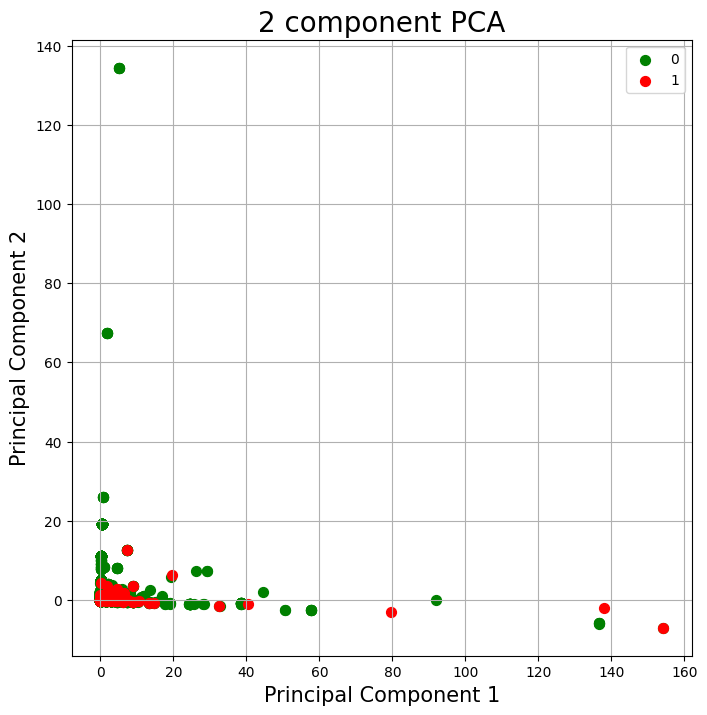

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]

colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['failure'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc 1']
               , finalDf.loc[indicesToKeep, 'pc 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Inference:
1. PCA attributes don't provide lot of extra detail other than confirming two attributes are same since explained variance for 8 and 9 attributes is equal.

### Pairplots

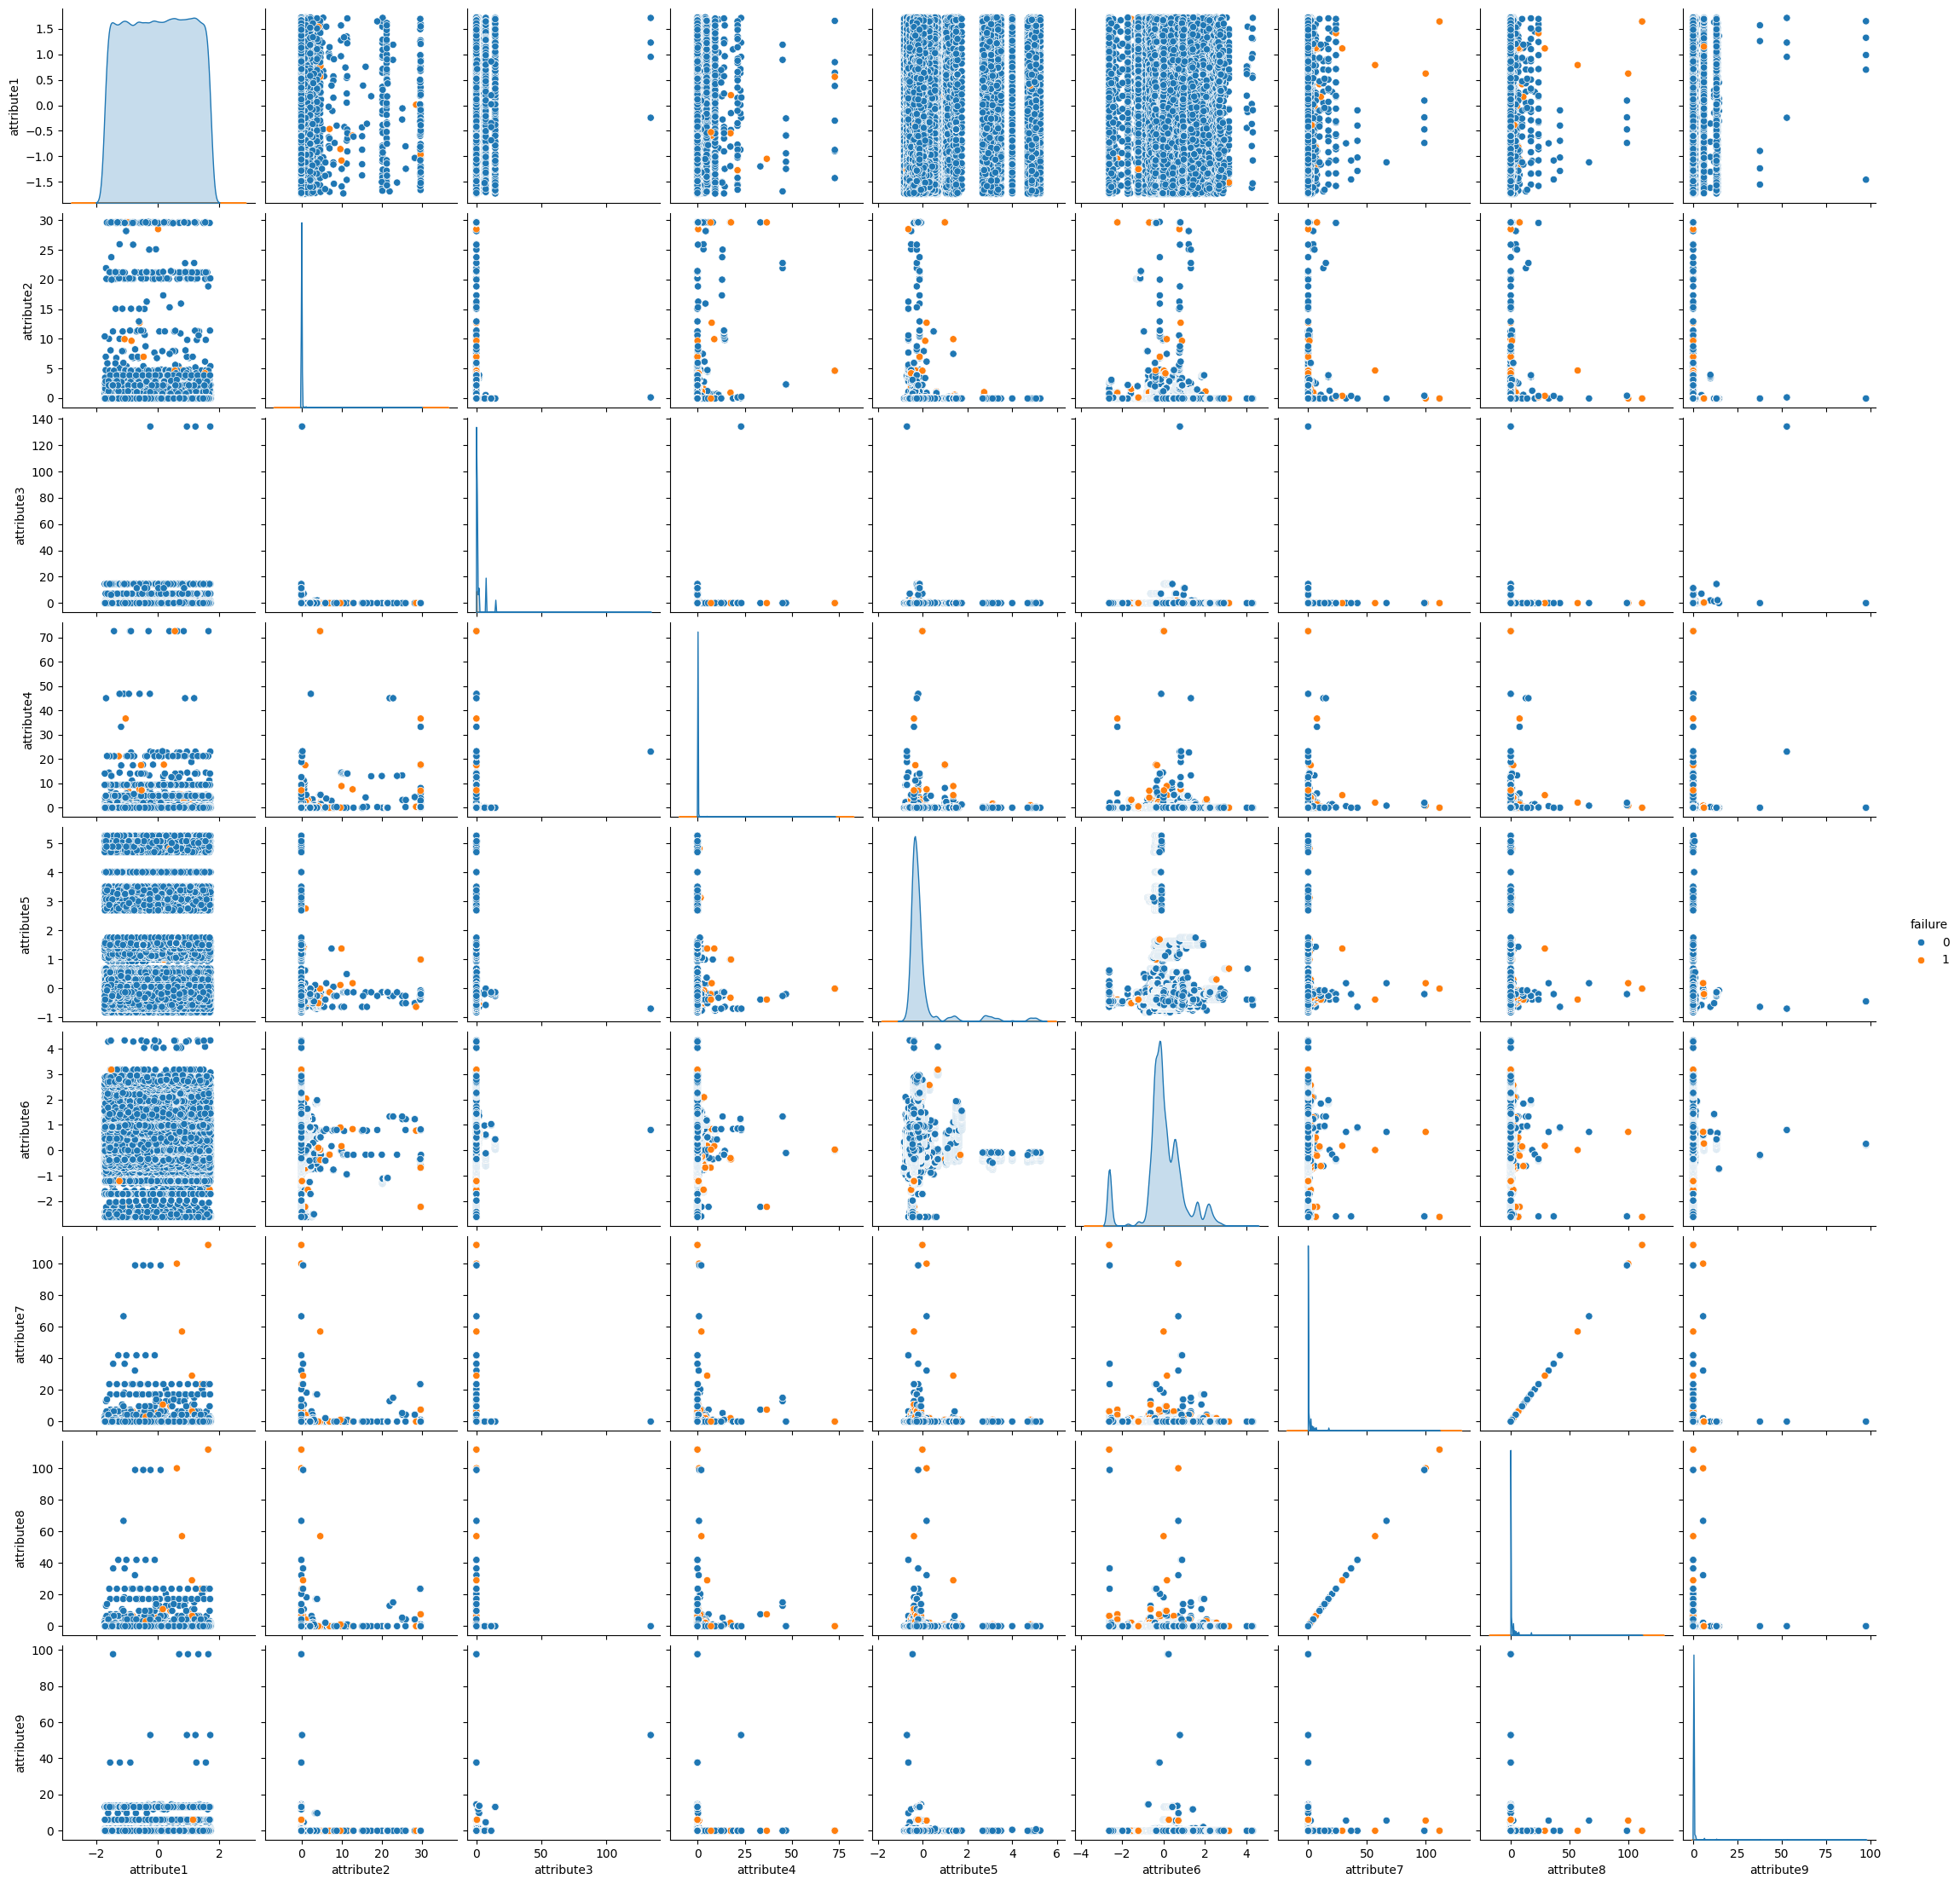

In [ ]:
X_scaled['failure'] = df['failure']
sns.pairplot(X_scaled, hue='failure')

From this, we can conclude that <b>Attribute 7 and attribute 8 are the same so one of them can be dropped. </b>
<br>All the other attributes provide some amount of variance to the data, hence are important.

## Baseline Models

### Naive-Model : Always 0

In [ ]:
x_train_orig, x_test_orig, y_train_orig, y_test_orig = prep_data(df)

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,122386752.674,159.485,9.940,1.741,14.223,260172.858,0.293,12.452
std,70459597.488,2179.658,185.747,22.909,15.943,99151.010,7.437,191.426
min,0.000,0.000,0.000,0.000,1.000,8.000,0.000,0.000
25%,61276754.000,0.000,0.000,0.000,8.000,221452.000,0.000,0.000
50%,122795744.000,0.000,0.000,0.000,10.000,249799.500,0.000,0.000
75%,183308370.000,0.000,0.000,0.000,12.000,310266.000,0.000,0.000
max,244140480.000,64968.000,24929.000,1666.000,98.000,689161.000,832.000,18701.000


,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-1.737,-0.073,-0.054,-0.076,-0.829,-2.624,-0.039,-0.065
25%,-0.867,-0.073,-0.054,-0.076,-0.390,-0.391,-0.039,-0.065
50%,0.006,-0.073,-0.054,-0.076,-0.265,-0.105,-0.039,-0.065
75%,0.865,-0.073,-0.054,-0.076,-0.139,0.505,-0.039,-0.065
max,1.728,29.733,134.156,72.648,5.255,4.327,111.835,97.629


Value counts: 
y_test
failure
0    31097
1       27
Name: count, dtype: int64
y_train
failure
0    93291
1       79
Name: count, dtype: int64


In [ ]:
y_pred_orig = [0] * y_test_orig.shape[0]  # Naive Model (Baseline)

evaluate(y_test_orig, y_pred_orig)

Confusion Matrix: 
[[31097     0]
 [   27     0]]


Classification Report:
              precision    recall  f1-score   support

           0     0.9991    1.0000    0.9996     31097
           1     0.0000    0.0000    0.0000        27

    accuracy                         0.9991     31124
   macro avg     0.4996    0.5000    0.4998     31124
weighted avg     0.9983    0.9991    0.9987     31124

0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
detailed_metrics(y_test_orig, y_pred_orig, x_test_orig)

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
tns,-0.006,0.003,-0.007,-0.003,-0.009,0.002,-0.003,0.000
fps,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fns,0.008,1.725,-0.037,2.627,-0.042,-0.117,4.144,0.175
tps,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Distance from mean of classes

In [ ]:
test = df.drop(['date', 'device', 'failure', 'attribute8'], axis=1)

scaler = preprocessing.StandardScaler()
test_scaled = pd.DataFrame(scaler.fit_transform(test), columns=test.columns)

In [ ]:
test_scaled.describe()
test_scaled['failure'] = df['failure']
grouped = test_scaled.groupby(['failure']).agg(np.mean)
grouped

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
failure,,,,,,,,
0,-0.000,-0.002,0.000,-0.002,-0.000,0.000,-0.003,-0.000
1,0.068,1.812,-0.032,2.309,0.078,-0.019,4.078,0.056


In [ ]:
temp = pd.DataFrame(test_scaled, columns=grouped.columns)
temp

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
0,1.323,-0.047,-0.054,2.194,-0.516,1.485,-0.039,-0.028
1,-0.866,-0.073,-0.037,-0.076,-0.516,1.442,-0.039,-0.065
2,0.723,-0.073,-0.054,-0.076,-0.139,-0.230,-0.039,-0.065
3,-0.606,-0.073,-0.054,-0.076,-0.516,1.513,-0.039,-0.065
4,0.193,-0.073,-0.054,-0.076,0.049,0.535,-0.039,-0.049
...,...,...,...,...,...,...,...,...
124489,-1.477,-0.073,-0.054,-0.076,-0.265,0.943,1.036,-0.065
124490,0.712,-0.029,0.523,0.099,-0.202,0.732,-0.039,0.003
124491,-1.467,2.144,-0.054,-0.076,-0.202,0.910,-0.039,-0.065
124492,1.484,-0.073,-0.054,-0.076,-0.139,0.997,-0.039,-0.065


In [ ]:
temp['failure'] = df['failure']
grouped = temp.groupby(['failure']).agg(np.mean)
grouped

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
failure,,,,,,,,
0,-0.000,-0.002,0.000,-0.002,-0.000,0.000,-0.003,-0.000
1,0.068,1.812,-0.032,2.309,0.078,-0.019,4.078,0.056


In [ ]:
def bs_2_mean_vectorised(df, grouped):
    df['dist_0'] = np.linalg.norm(df[attr_cols] - grouped.values[0], axis=1)
    df['dist_1'] = np.linalg.norm(df[attr_cols] - grouped.values[1], axis=1)

    df['bs_2_mean'] = np.where(df['dist_1'] < df['dist_0'], 1, 0)
    return df

res = bs_2_mean_vectorised(test_scaled, grouped)
res.describe()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,failure,dist_0,dist_1,bs_2_mean
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.001,1.686,5.477,0.007
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.029,2.271,1.806,0.084
min,-1.737,-0.073,-0.054,-0.076,-0.829,-2.624,-0.039,-0.065,0.000,0.147,2.343,0.000
25%,-0.867,-0.073,-0.054,-0.076,-0.390,-0.391,-0.039,-0.065,0.000,0.878,5.184,0.000
50%,0.006,-0.073,-0.054,-0.076,-0.265,-0.105,-0.039,-0.065,0.000,1.352,5.278,0.000
75%,0.865,-0.073,-0.054,-0.076,-0.139,0.505,-0.039,-0.065,0.000,1.838,5.424,0.000
max,1.728,29.733,134.156,72.648,5.255,4.327,111.835,97.629,1.000,146.045,145.776,1.000


In [ ]:
evaluate(res['failure'], res['bs_2_mean'])

Confusion Matrix: 
[[123536    852]
 [    73     33]]


Classification Report:
              precision    recall  f1-score   support

           0     0.9994    0.9932    0.9963    124388
           1     0.0373    0.3113    0.0666       106

    accuracy                         0.9926    124494
   macro avg     0.5183    0.6522    0.5314    124494
weighted avg     0.9986    0.9926    0.9955    124494

0.3113207547169811


In [ ]:
detailed_metrics(res['failure'], res['bs_2_mean'], res[attr_cols])

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
tns,-0.000,-0.041,-0.004,-0.041,0.003,0.001,-0.029,-0.001
fps,0.002,5.746,0.590,5.705,-0.381,-0.133,3.684,0.204
fns,0.053,0.326,-0.024,0.264,0.189,0.056,0.252,0.027
tps,0.101,5.099,-0.050,6.833,-0.168,-0.185,12.543,0.119


## Traditional Approaches

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X = X_scaled[attr_cols]
y = df['failure']

In [ ]:
clf = LogisticRegression(random_state=0).fit(X, y)
log_reg_predictions = clf.predict(X)

clf.predict_proba(X)


clf.score(X, y)

0.9991565858595595

In [ ]:
evaluate(y, log_reg_predictions)

Confusion Matrix: 
[[124387      1]
 [   104      2]]


Classification Report:
              precision    recall  f1-score   support

           0     0.9992    1.0000    0.9996    124388
           1     0.6667    0.0189    0.0367       106

    accuracy                         0.9992    124494
   macro avg     0.8329    0.5094    0.5181    124494
weighted avg     0.9989    0.9992    0.9988    124494

0.018867924528301886


Inference:
1. Due to the class imbalance, almost always predicts 0.
2. Good thing is it doesn't start predicting false positives.

### Gaussian Naive-Bayes

In [ ]:
X = df[attr_cols]
y = df['failure']

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X, y)

gaussian_nb_predictions = clf.predict(X)

evaluate(y, gaussian_nb_predictions)

Confusion Matrix: 
[[124163    225]
 [    98      8]]


Classification Report:
              precision    recall  f1-score   support

           0     0.9992    0.9982    0.9987    124388
           1     0.0343    0.0755    0.0472       106

    accuracy                         0.9974    124494
   macro avg     0.5168    0.5368    0.5229    124494
weighted avg     0.9984    0.9974    0.9979    124494

0.07547169811320754


Inference:
1. Gives lot of false positives so unacceptable

## Upsampling Techniques

In [ ]:
# !sudo -H /home/ubuntu/Notebooks/DEV_ENV/bin/python3 -m pip install -U imbalanced-learn

In [ ]:
attr_cols = [col for col in df.columns if 'attr' in col and '8' not in col]

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter

df.reset_index(inplace=True, drop=True)
X = df[attr_cols]
y = df['failure']

scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_resampled, y_resampled = BorderlineSMOTE().fit_resample(X_scaled, y)
print(sorted(Counter(y_resampled).items()))

[(0, 124388), (1, 124388)]


In [ ]:
df_resampled = pd.concat(
    [
        pd.DataFrame(X_resampled, columns=attr_cols),
        pd.DataFrame(y_resampled, columns=['failure'])
    ],
    axis=1)

df_resampled

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,failure
0,1.323,-0.047,-0.054,2.194,-0.516,1.485,-0.039,-0.028,0
1,-0.866,-0.073,-0.037,-0.076,-0.516,1.442,-0.039,-0.065,0
2,0.723,-0.073,-0.054,-0.076,-0.139,-0.230,-0.039,-0.065,0
3,-0.606,-0.073,-0.054,-0.076,-0.516,1.513,-0.039,-0.065,0
4,0.193,-0.073,-0.054,-0.076,0.049,0.535,-0.039,-0.049,0
...,...,...,...,...,...,...,...,...,...
248771,0.061,28.807,-0.050,4.859,-0.214,0.476,0.243,-0.065,1
248772,0.471,-0.073,-0.025,0.608,-0.014,0.273,70.272,3.698,1
248773,1.058,0.331,-0.054,4.647,1.220,0.171,27.395,-0.055,1
248774,1.030,-0.073,-0.054,0.893,1.776,-0.210,1.036,-0.016,1


In [ ]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.25)

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
brf.fit(X_train_resampled, y_train_resampled)

y_pred_bfr = brf.predict(X_test_resampled)
print(balanced_accuracy_score(y_test_resampled, y_pred_bfr) )

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.para

0.9993737673357264


In [ ]:
evaluate(y_test_resampled, y_pred_bfr)

Confusion Matrix: 
[[31025     7]
 [   32 31130]]


Classification Report:
              precision    recall  f1-score   support

           0     0.9990    0.9998    0.9994     31032
           1     0.9998    0.9990    0.9994     31162

    accuracy                         0.9994     62194
   macro avg     0.9994    0.9994    0.9994     62194
weighted avg     0.9994    0.9994    0.9994     62194

0.9989731082728964


In [ ]:
y_pred_orig_bfr = brf.predict(x_test_orig)

evaluate(y_test_orig, y_pred_orig_bfr)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BalancedRandomForestClassifier was fitted without feature names
  warnings.warn(


Confusion Matrix: 
[[31096     1]
 [    8    19]]


Classification Report:
              precision    recall  f1-score   support

           0     0.9997    1.0000    0.9999     31097
           1     0.9500    0.7037    0.8085        27

    accuracy                         0.9997     31124
   macro avg     0.9749    0.8518    0.9042     31124
weighted avg     0.9997    0.9997    0.9997     31124

0.7037037037037037


In [ ]:
from joblib import dump, load
dump(brf, 'brf_final.joblib')

['brf_final.joblib']

<Axes: >

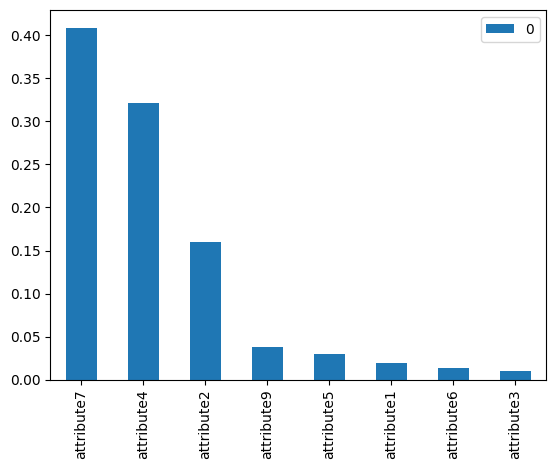

In [ ]:
# features = pd.DataFrame(columns=attr_cols)
features = pd.DataFrame(brf.feature_importances_, index=attr_cols)
features.sort_values(by=[0], ascending=False).plot(kind='bar')

## Deep Learning Approaches

### With class_weights / Resampled Data

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=8, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=4, verbose=0, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0
)

In [ ]:
def make_model():
    model = keras.Sequential([
        keras.layers.Input(shape=(x_train_orig.shape[1], )),
#         keras.layers.Dense(256, activation=tf.nn.relu),
#         keras.layers.Dense(128, activation=tf.nn.relu),
#         keras.layers.Dense(64, activation=tf.nn.relu),
#         keras.layers.Dense(32, activation=tf.nn.relu),
#         keras.layers.Dense(16, activation=tf.nn.relu),
        keras.layers.Dense(16, activation=tf.nn.relu),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(8, activation=tf.nn.relu),
#         keras.layers.Dropout(0.25),
        keras.layers.Dense(4, activation=tf.nn.relu),
        keras.layers.Dense(1, activation=tf.nn.sigmoid),
    ])

    model.compile(optimizer=keras.optimizers.Adam(lr=1e-2),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    print(model.summary())
    return model

In [ ]:
model = make_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                144       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# del model

In [ ]:
history = model.fit(
#                     x_train_orig, y_train_orig,
#                     class_weight={0:0.01, 1:1},
                    X_train_resampled, y_train_resampled,
                    epochs=200,
                    batch_size=512,
                    callbacks=[early_stopping, reduce_lr_on_plateau],

                    validation_data=(X_test_resampled, y_test_resampled),
                    shuffle=True,
)

Epoch 1/200
365/365 [==============================] - 3s 4ms/step - loss: 1.0136 - accuracy: 0.7489 - precision: 0.8698 - recall: 0.5850 - val_loss: 0.2170 - val_accuracy: 0.9802 - val_precision: 0.9921 - val_recall: 0.9683 - lr: 0.0010
Epoch 2/200
365/365 [==============================] - 1s 3ms/step - loss: 0.1387 - accuracy: 0.9785 - precision: 0.9763 - recall: 0.9807 - val_loss: 0.0714 - val_accuracy: 0.9892 - val_precision: 0.9870 - val_recall: 0.9915 - lr: 0.0010
Epoch 3/200
365/365 [==============================] - 1s 3ms/step - loss: 0.0690 - accuracy: 0.9856 - precision: 0.9800 - recall: 0.9915 - val_loss: 0.0496 - val_accuracy: 0.9904 - val_precision: 0.9885 - val_recall: 0.9924 - lr: 0.0010
Epoch 4/200
365/365 [==============================] - 1s 3ms/step - loss: 0.0527 - accuracy: 0.9877 - precision: 0.9829 - recall: 0.9926 - val_loss: 0.0414 - val_accuracy: 0.9913 - val_precision: 0.9897 - val_recall: 0.9930 - lr: 0.0010
Epoch 5/200
365/365 [===========================

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'lr'])


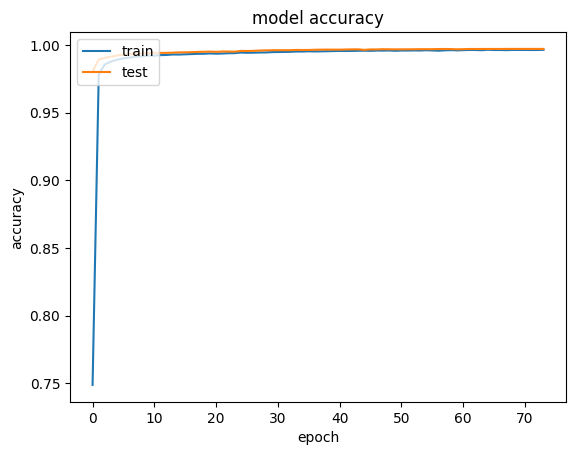

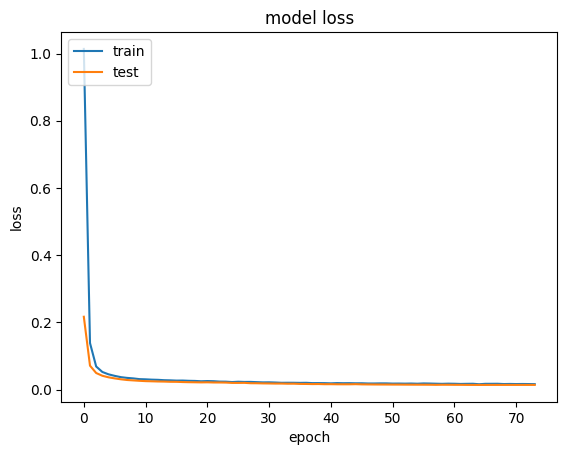

In [ ]:
plot_history(history)

In [ ]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = prep_data(df)

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,122386752.674,159.485,9.940,1.741,14.223,260172.858,0.293,12.452
std,70459597.488,2179.658,185.747,22.909,15.943,99151.010,7.437,191.426
min,0.000,0.000,0.000,0.000,1.000,8.000,0.000,0.000
25%,61276754.000,0.000,0.000,0.000,8.000,221452.000,0.000,0.000
50%,122795744.000,0.000,0.000,0.000,10.000,249799.500,0.000,0.000
75%,183308370.000,0.000,0.000,0.000,12.000,310266.000,0.000,0.000
max,244140480.000,64968.000,24929.000,1666.000,98.000,689161.000,832.000,18701.000


,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-1.737,-0.073,-0.054,-0.076,-0.829,-2.624,-0.039,-0.065
25%,-0.867,-0.073,-0.054,-0.076,-0.390,-0.391,-0.039,-0.065
50%,0.006,-0.073,-0.054,-0.076,-0.265,-0.105,-0.039,-0.065
75%,0.865,-0.073,-0.054,-0.076,-0.139,0.505,-0.039,-0.065
max,1.728,29.733,134.156,72.648,5.255,4.327,111.835,97.629


Value counts: 
y_test
failure
0    31097
1       27
Name: count, dtype: int64
y_train
failure
0    93291
1       79
Name: count, dtype: int64


In [ ]:
answer = model.evaluate(x_test_orig, y_test_orig)
print('Loss, accuracy, precision, recall:', answer)

973/973 [==============================] - 2s 2ms/step - loss: 0.0228 - accuracy: 0.9948 - precision: 0.0641 - recall: 0.3704
Loss, accuracy, precision, recall: [0.022802919149398804, 0.9947628974914551, 0.06410256773233414, 0.37037035822868347]


In [ ]:
y_pred = (model.predict(x_test_orig) > 0.5).astype("int32")
evaluate(y_test_orig, y_pred)

973/973 [==============================] - 1s 1ms/step
Confusion Matrix: 
[[30951   146]
 [   17    10]]


Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9953    0.9974     31097
           1     0.0641    0.3704    0.1093        27

    accuracy                         0.9948     31124
   macro avg     0.5318    0.6828    0.5533     31124
weighted avg     0.9986    0.9948    0.9966     31124

0.37037037037037035


In [ ]:
detailed_metrics(y_test_orig, y_pred, X_test_orig )

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
tns,-0.007,-0.014,-0.007,-0.022,-0.008,0.003,-0.019,0.000
fps,0.076,3.525,-0.052,3.950,-0.131,-0.068,3.407,-0.016
fns,-0.117,0.036,-0.028,1.311,0.004,-0.032,0.150,0.296
tps,0.219,4.597,-0.053,4.865,-0.121,-0.262,10.933,-0.031


### With careful bias

In [ ]:
neg, pos = np.bincount(df['failure'])

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(x_train_orig.shape[1],)),
      keras.layers.Dropout(0.25),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(4, activation='relu'),
        keras.layers.Dense(2, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [ ]:
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='loss', min_delta=0, patience=15, verbose=0, mode='auto',
#     baseline=None, restore_best_weights=True
# )

EPOCHS = 100
BATCH_SIZE = 512

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

In [ ]:
# def make_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(x_train_orig.shape[1], )),
# #         keras.layers.Dense(256, activation=tf.nn.relu),
# #         keras.layers.Dense(128, activation=tf.nn.relu),
# #         keras.layers.Dense(64, activation=tf.nn.relu),
# #         keras.layers.Dense(32, activation=tf.nn.relu),
# #         keras.layers.Dense(16, activation=tf.nn.relu),
#         keras.layers.Dense(8, activation=tf.nn.relu),
#         keras.layers.Dense(4, activation=tf.nn.relu),
#         keras.layers.Dense(1, activation=tf.nn.sigmoid),
#     ])

#     model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
#     print(model.summary())
#     return model

In [ ]:
model = make_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                144       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 4)                 36        
                                                                 
 dense_7 (Dense)             (None, 2)                 10        
                                                                 
 dense_8 (Dense)             (None, 1)                 3         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.2

In [ ]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = prep_data(df)

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,122386752.674,159.485,9.940,1.741,14.223,260172.858,0.293,12.452
std,70459597.488,2179.658,185.747,22.909,15.943,99151.010,7.437,191.426
min,0.000,0.000,0.000,0.000,1.000,8.000,0.000,0.000
25%,61276754.000,0.000,0.000,0.000,8.000,221452.000,0.000,0.000
50%,122795744.000,0.000,0.000,0.000,10.000,249799.500,0.000,0.000
75%,183308370.000,0.000,0.000,0.000,12.000,310266.000,0.000,0.000
max,244140480.000,64968.000,24929.000,1666.000,98.000,689161.000,832.000,18701.000


,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-1.737,-0.073,-0.054,-0.076,-0.829,-2.624,-0.039,-0.065
25%,-0.867,-0.073,-0.054,-0.076,-0.390,-0.391,-0.039,-0.065
50%,0.006,-0.073,-0.054,-0.076,-0.265,-0.105,-0.039,-0.065
75%,0.865,-0.073,-0.054,-0.076,-0.139,0.505,-0.039,-0.065
max,1.728,29.733,134.156,72.648,5.255,4.327,111.835,97.629


Value counts: 
y_test
failure
0    31097
1       27
Name: count, dtype: int64
y_train
failure
0    93291
1       79
Name: count, dtype: int64


In [ ]:
model.predict(X_train_orig[:10])

1/1 [==============================] - 0s 67ms/step


array([[0.37794283],
       [0.3775411 ],
       [0.3775411 ],
       [0.3766434 ],
       [0.3775411 ],
       [0.3775411 ],
       [0.3775411 ],
       [0.37654644],
       [0.3775411 ],
       [0.3775411 ]], dtype=float32)

In [ ]:
results = model.evaluate(X_train_orig, y_train_orig, batch_size=BATCH_SIZE, verbose=1)
print("Loss: {:0.4f}".format(results[0]))

183/183 [==============================] - 1s 2ms/step - loss: 0.4739 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 93291.0000 - fn: 79.0000 - accuracy: 0.9992 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4934
Loss: 0.4739


In [ ]:
initial_bias = np.log(-np.log([pos/neg]))
initial_bias

array([1.95553821])

In [ ]:
model = make_model(output_bias=initial_bias)
model.predict(X_test_orig[:10])

1/1 [==============================] - 0s 74ms/step


array([[0.9070218 ],
       [0.8760493 ],
       [0.89573216],
       [0.9074818 ],
       [0.9161754 ],
       [0.8760493 ],
       [0.8760493 ],
       [0.8760493 ],
       [0.8839538 ],
       [0.8760493 ]], dtype=float32)

In [ ]:
results = model.evaluate(X_train_orig, y_train_orig, batch_size=BATCH_SIZE, verbose=True)
print("Loss: {:0.4f}".format(results[0]))

183/183 [==============================] - 3s 5ms/step - loss: 2.2816 - tp: 79.0000 - fp: 93291.0000 - tn: 93291.0000 - fn: 79.0000 - accuracy: 0.5000 - precision: 8.4610e-04 - recall: 0.5000 - auc: 0.5306
Loss: 2.2816


In [ ]:
import os
import tempfile
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
#  model.fit(
#     X_train,
#     y_train,
#     batch_size=BATCH_SIZE,
#     epochs=20,
# #     validation_data=(val_features, val_labels),
#     verbose=0)

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch, history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train_orig,
    y_train_orig,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_test_orig, y_test_orig),
    verbose=1)

Epoch 1/20
183/183 [==============================] - 3s 6ms/step - loss: 0.6666 - tp: 91.0000 - fp: 102800.0000 - tn: 177073.0000 - fn: 146.0000 - accuracy: 0.6325 - precision: 8.8443e-04 - recall: 0.3840 - auc: 0.5112 - val_loss: 0.6092 - val_tp: 0.0000e+00 - val_fp: 12.0000 - val_tn: 31085.0000 - val_fn: 27.0000 - val_accuracy: 0.9987 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4994
Epoch 2/20
183/183 [==============================] - 1s 3ms/step - loss: 0.5719 - tp: 1.0000 - fp: 67.0000 - tn: 93224.0000 - fn: 78.0000 - accuracy: 0.9984 - precision: 0.0147 - recall: 0.0127 - auc: 0.4540 - val_loss: 0.5352 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 31097.0000 - val_fn: 27.0000 - val_accuracy: 0.9991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 3/20
183/183 [==============================] - 1s 3ms/step - loss: 0.5027 - tp: 0.0000e+00 - fp: 6.0000 - tn: 93285.0000 - fn: 79.0000 - accuracy: 0.9991 - precision: 0.0000e+00 -

In [ ]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train_orig,
    y_train_orig,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_test_orig, y_test_orig),
    verbose=True)

Epoch 1/20
183/183 [==============================] - 4s 6ms/step - loss: 2.0325 - tp: 79.0000 - fp: 93291.0000 - tn: 93291.0000 - fn: 79.0000 - accuracy: 0.5000 - precision: 8.4610e-04 - recall: 0.5000 - auc: 0.4969 - val_loss: 1.9295 - val_tp: 27.0000 - val_fp: 31097.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 8.6750e-04 - val_precision: 8.6750e-04 - val_recall: 1.0000 - val_auc: 0.4997
Epoch 2/20
183/183 [==============================] - 1s 3ms/step - loss: 1.8544 - tp: 79.0000 - fp: 93291.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 8.4610e-04 - precision: 8.4610e-04 - recall: 1.0000 - auc: 0.4762 - val_loss: 1.7780 - val_tp: 27.0000 - val_fp: 31097.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 8.6750e-04 - val_precision: 8.6750e-04 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/20
183/183 [==============================] - 1s 3ms/step - loss: 1.7060 - tp: 79.0000 - fp: 93291.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 8.4610e-04 - 

In [ ]:
results = model.evaluate(X_train_orig, y_train_orig, batch_size=BATCH_SIZE, verbose=True)
print("Loss: {:0.4f}".format(results[0]))

183/183 [==============================] - 0s 2ms/step - loss: 0.3069 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 93291.0000 - fn: 79.0000 - accuracy: 0.9992 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
Loss: 0.3069


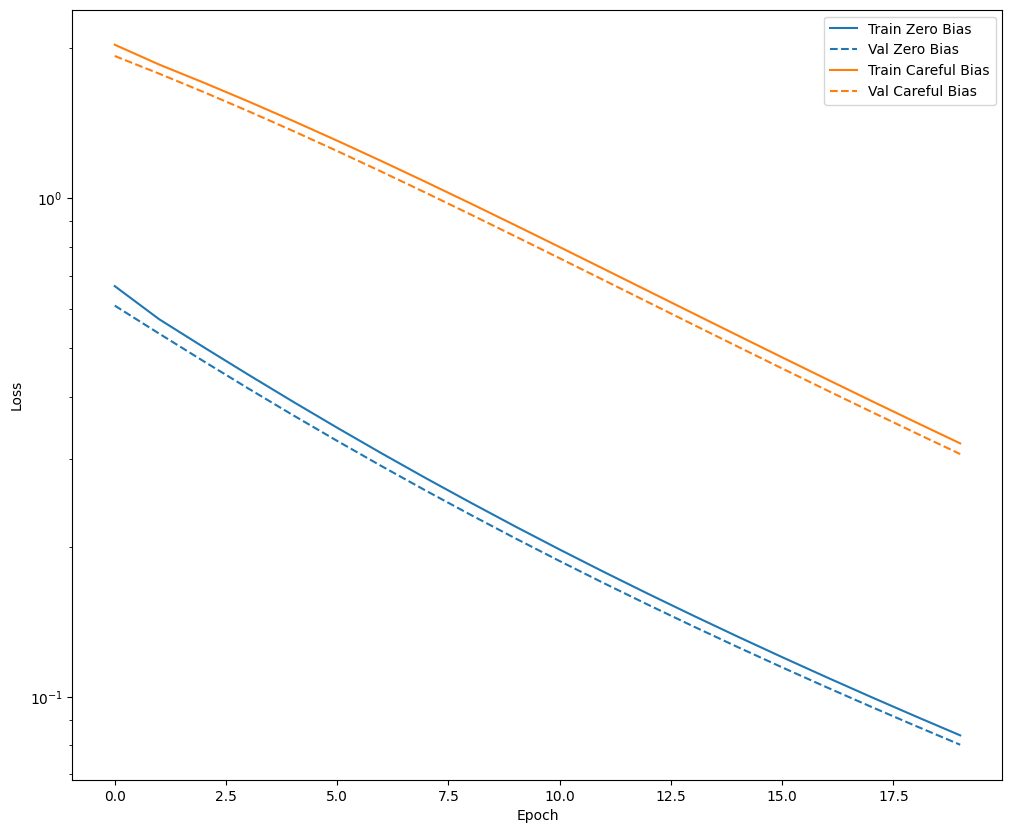

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train_orig,
    y_train_orig,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(x_test_orig, y_test_orig))

Epoch 1/100
183/183 [==============================] - 3s 6ms/step - loss: 2.0325 - tp: 79.0000 - fp: 93291.0000 - tn: 93291.0000 - fn: 79.0000 - accuracy: 0.5000 - precision: 8.4610e-04 - recall: 0.5000 - auc: 0.5237 - val_loss: 1.9295 - val_tp: 27.0000 - val_fp: 31097.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 8.6750e-04 - val_precision: 8.6750e-04 - val_recall: 1.0000 - val_auc: 0.4995
Epoch 2/100
183/183 [==============================] - 1s 3ms/step - loss: 1.8542 - tp: 79.0000 - fp: 93291.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 8.4610e-04 - precision: 8.4610e-04 - recall: 1.0000 - auc: 0.5097 - val_loss: 1.7780 - val_tp: 27.0000 - val_fp: 31097.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 8.6750e-04 - val_precision: 8.6750e-04 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/100
183/183 [==============================] - 1s 3ms/step - loss: 1.7058 - tp: 79.0000 - fp: 93291.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 8.4610e-04

In [ ]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()


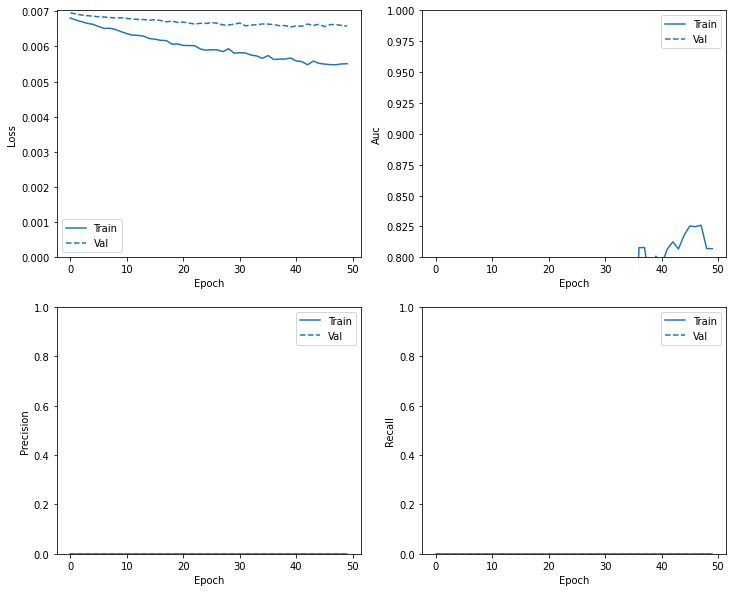

In [ ]:
plot_metrics(baseline_history)

In [ ]:
train_predictions_baseline = model.predict(X_train_orig, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test_orig, batch_size=BATCH_SIZE)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.0063798511400818825
tp :  0.0
fp :  0.0
tn :  31097.0
fn :  27.0
accuracy :  0.999132513999939
precision :  0.0
recall :  0.0
auc :  0.6984923481941223

Legitimate Transactions Detected (True Negatives):  31097
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  27
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  27


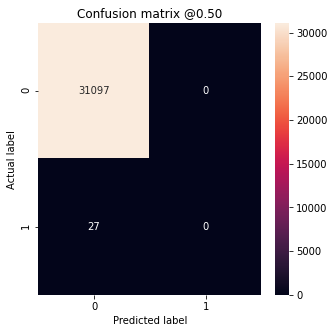

In [ ]:
baseline_results = model.evaluate(X_test_orig, y_test_orig,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(y_test_orig, test_predictions_baseline)

#### class weights

In [ ]:
total = neg + pos
weight_for_0 = (1 / neg)*(total)/2.0
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 587.24


In [ ]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train_orig,
    y_train_orig,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_test_orig, y_test_orig),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100
183/183 [==============================] - 2s 11ms/step - loss: 0.9797 - tp: 61.0000 - fp: 76821.0000 - tn: 47567.0000 - fn: 45.0000 - accuracy: 0.3826 - precision: 7.9342e-04 - recall: 0.5755 - auc: 0.5090 - val_loss: 0.6498 - val_tp: 17.0000 - val_fp: 11100.0000 - val_tn: 19997.0000 - val_fn: 10.0000 - val_accuracy: 0.6430 - val_precision: 0.0015 - val_recall: 0.6296 - val_auc: 0.6554
Epoch 2/100
183/183 [==============================] - 1s 6ms/step - loss: 0.7033 - tp: 50.0000 - fp: 31688.0000 - tn: 61603.0000 - fn: 29.0000 - accuracy: 0.6603 - precision: 0.0016 - recall: 0.6329 - auc: 0.6616 - val_loss: 0.5454 - val_tp: 16.0000 - val_fp: 4753.0000 - val_tn: 26344.0000 - val_fn: 11.0000 - val_accuracy: 0.8469 - val_precision: 0.0034 - val_recall: 0.5926 - val_auc: 0.7319
Epoch 3/100
183/183 [==============================] - 1s 6ms/step - loss: 0.7988 - tp: 49.0000 - fp: 25410.0000 - tn: 67881.0000 - fn: 30.0000 - accuracy: 0.7275 - precision: 0.0019 - recall: 0.6203 - 

Epoch 22/100
183/183 [==============================] - 1s 6ms/step - loss: 0.4868 - tp: 52.0000 - fp: 11261.0000 - tn: 82030.0000 - fn: 27.0000 - accuracy: 0.8791 - precision: 0.0046 - recall: 0.6582 - auc: 0.8301 - val_loss: 0.4116 - val_tp: 16.0000 - val_fp: 1915.0000 - val_tn: 29182.0000 - val_fn: 11.0000 - val_accuracy: 0.9381 - val_precision: 0.0083 - val_recall: 0.5926 - val_auc: 0.7898
Epoch 23/100
183/183 [==============================] - 1s 6ms/step - loss: 0.4396 - tp: 60.0000 - fp: 13174.0000 - tn: 80117.0000 - fn: 19.0000 - accuracy: 0.8587 - precision: 0.0045 - recall: 0.7595 - auc: 0.8722 - val_loss: 0.2925 - val_tp: 16.0000 - val_fp: 1379.0000 - val_tn: 29718.0000 - val_fn: 11.0000 - val_accuracy: 0.9553 - val_precision: 0.0115 - val_recall: 0.5926 - val_auc: 0.7998
Epoch 24/100
183/183 [==============================] - 1s 6ms/step - loss: 0.4663 - tp: 55.0000 - fp: 10285.0000 - tn: 83006.0000 - fn: 24.0000 - accuracy: 0.8896 - precision: 0.0053 - recall: 0.6962 - auc

In [ ]:
train_predictions_weighted = weighted_model.predict(X_train_orig, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test_orig, batch_size=BATCH_SIZE)

loss :  0.29245826601982117
tp :  16.0
fp :  1379.0
tn :  29718.0
fn :  11.0
accuracy :  0.9553399085998535
precision :  0.011469533666968346
recall :  0.5925925970077515
auc :  0.7997674942016602

Legitimate Transactions Detected (True Negatives):  29718
Legitimate Transactions Incorrectly Detected (False Positives):  1379
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  16
Total Fraudulent Transactions:  27


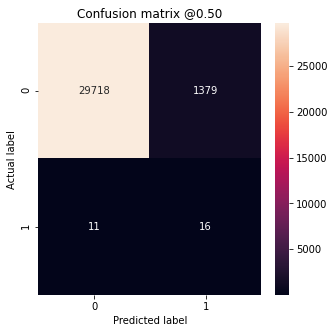

In [ ]:
weighted_results = weighted_model.evaluate(X_test_orig, y_test_orig,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(y_test_orig, test_predictions_weighted)

In [ ]:
evaluate(y_test_orig, test_predictions_weighted > 0.5)
# test_predictions_weighted > 0.5

Confusion Matrix: 
[[29718  1379]
 [   11    16]]


Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9557    0.9771     31097
           1     0.0115    0.5926    0.0225        27

    accuracy                         0.9553     31124
   macro avg     0.5055    0.7741    0.4998     31124
weighted avg     0.9988    0.9553    0.9763     31124



In [ ]:
# End of careful bias section

In [ ]:
# bool_train_labels = y != 0
# pos_features = X_train[bool_train_labels]
# neg_features = X_train[~bool_train_labels]

# pos_labels = y_train[bool_train_labels]
# neg_labels = y_train[~bool_train_labels]

In [ ]:
# ids = np.arange(len(pos_features))
# choices = np.random.choice(ids, len(neg_features))

# res_pos_features = pos_features[choices]
# res_pos_labels = pos_labels[choices]

# res_pos_features.shape

In [ ]:
# model.fit(X_resampled, y_resampled, class_weight=class_weights)

In [ ]:
history = model.fit(
#                     x_train_orig, y_train_orig,
                    X_resampled, y_resampled,
                    epochs=200,
                    batch_size=256,
                    callbacks=[early_stopping],
#                     class_weight={0:0.01, 1:1},

                    shuffle=True
                   )

Epoch 1/200
972/972 [==============================] - 5s 5ms/step - loss: 1.9585 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 124388.0000 - fn: 124388.0000 - accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9643
Epoch 2/200
972/972 [==============================] - 5s 5ms/step - loss: 1.3339 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 124388.0000 - fn: 124388.0000 - accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9839
Epoch 3/200
972/972 [==============================] - 5s 5ms/step - loss: 0.8939 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 124388.0000 - fn: 124388.0000 - accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9878
Epoch 4/200
972/972 [==============================] - 5s 5ms/step - loss: 0.5657 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 124388.0000 - fn: 124388.0000 - accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9902
Epoch 5/200
972/972 [==============================] - 5s 5ms/step - loss: 0.345

Epoch 15/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0215 - tp: 124213.0000 - fp: 912.0000 - tn: 123476.0000 - fn: 175.0000 - accuracy: 0.9956 - precision: 0.9927 - recall: 0.9986 - auc: 0.9981
Epoch 16/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0202 - tp: 124235.0000 - fp: 861.0000 - tn: 123527.0000 - fn: 153.0000 - accuracy: 0.9959 - precision: 0.9931 - recall: 0.9988 - auc: 0.9982
Epoch 17/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0200 - tp: 124231.0000 - fp: 851.0000 - tn: 123537.0000 - fn: 157.0000 - accuracy: 0.9959 - precision: 0.9932 - recall: 0.9987 - auc: 0.9982
Epoch 18/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0195 - tp: 124237.0000 - fp: 856.0000 - tn: 123532.0000 - fn: 151.0000 - accuracy: 0.9960 - precision: 0.9932 - recall: 0.9988 - auc: 0.9984
Epoch 19/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0190 - tp: 124236.0000 - fp: 824.0000 - tn: 12

972/972 [==============================] - 5s 5ms/step - loss: 0.0174 - tp: 124236.0000 - fp: 749.0000 - tn: 123639.0000 - fn: 152.0000 - accuracy: 0.9964 - precision: 0.9940 - recall: 0.9988 - auc: 0.9985
Epoch 44/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0179 - tp: 124231.0000 - fp: 755.0000 - tn: 123633.0000 - fn: 157.0000 - accuracy: 0.9963 - precision: 0.9940 - recall: 0.9987 - auc: 0.9984
Epoch 45/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0174 - tp: 124242.0000 - fp: 731.0000 - tn: 123657.0000 - fn: 146.0000 - accuracy: 0.9965 - precision: 0.9942 - recall: 0.9988 - auc: 0.9985
Epoch 46/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0173 - tp: 124255.0000 - fp: 723.0000 - tn: 123665.0000 - fn: 133.0000 - accuracy: 0.9966 - precision: 0.9942 - recall: 0.9989 - auc: 0.9984
Epoch 47/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0172 - tp: 124239.0000 - fp: 718.0000 - tn: 123670.0000 - f

972/972 [==============================] - 5s 5ms/step - loss: 0.0162 - tp: 124247.0000 - fp: 658.0000 - tn: 123730.0000 - fn: 141.0000 - accuracy: 0.9968 - precision: 0.9947 - recall: 0.9989 - auc: 0.9986
Epoch 72/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0162 - tp: 124255.0000 - fp: 659.0000 - tn: 123729.0000 - fn: 133.0000 - accuracy: 0.9968 - precision: 0.9947 - recall: 0.9989 - auc: 0.9986
Epoch 73/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0159 - tp: 124251.0000 - fp: 645.0000 - tn: 123743.0000 - fn: 137.0000 - accuracy: 0.9969 - precision: 0.9948 - recall: 0.9989 - auc: 0.9986
Epoch 74/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0164 - tp: 124246.0000 - fp: 666.0000 - tn: 123722.0000 - fn: 142.0000 - accuracy: 0.9968 - precision: 0.9947 - recall: 0.9989 - auc: 0.9985
Epoch 75/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0163 - tp: 124253.0000 - fp: 674.0000 - tn: 123714.0000 - f

972/972 [==============================] - 5s 5ms/step - loss: 0.0154 - tp: 124260.0000 - fp: 633.0000 - tn: 123755.0000 - fn: 128.0000 - accuracy: 0.9969 - precision: 0.9949 - recall: 0.9990 - auc: 0.9986
Epoch 100/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0154 - tp: 124253.0000 - fp: 617.0000 - tn: 123771.0000 - fn: 135.0000 - accuracy: 0.9970 - precision: 0.9951 - recall: 0.9989 - auc: 0.9986
Epoch 101/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0154 - tp: 124257.0000 - fp: 605.0000 - tn: 123783.0000 - fn: 131.0000 - accuracy: 0.9970 - precision: 0.9952 - recall: 0.9989 - auc: 0.9986
Epoch 102/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0157 - tp: 124246.0000 - fp: 621.0000 - tn: 123767.0000 - fn: 142.0000 - accuracy: 0.9969 - precision: 0.9950 - recall: 0.9989 - auc: 0.9986
Epoch 103/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0157 - tp: 124241.0000 - fp: 628.0000 - tn: 123760.0000

972/972 [==============================] - 5s 5ms/step - loss: 0.0155 - tp: 124239.0000 - fp: 617.0000 - tn: 123771.0000 - fn: 149.0000 - accuracy: 0.9969 - precision: 0.9951 - recall: 0.9988 - auc: 0.9986
Epoch 128/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0154 - tp: 124231.0000 - fp: 619.0000 - tn: 123769.0000 - fn: 157.0000 - accuracy: 0.9969 - precision: 0.9950 - recall: 0.9987 - auc: 0.9987
Epoch 129/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0157 - tp: 124259.0000 - fp: 624.0000 - tn: 123764.0000 - fn: 129.0000 - accuracy: 0.9970 - precision: 0.9950 - recall: 0.9990 - auc: 0.9985
Epoch 130/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0152 - tp: 124246.0000 - fp: 595.0000 - tn: 123793.0000 - fn: 142.0000 - accuracy: 0.9970 - precision: 0.9952 - recall: 0.9989 - auc: 0.9986
Epoch 131/200
972/972 [==============================] - 5s 5ms/step - loss: 0.0153 - tp: 124246.0000 - fp: 611.0000 - tn: 123777.0000

KeyboardInterrupt: 

In [ ]:
# plot_history(history)

In [ ]:
answer = model.evaluate(x_test_orig, y_test_orig)
print('Loss, accuracy, precision, recall:', answer)

In [ ]:
y_pred = (model.predict(x_test_orig) > 0.5).astype("int32")
evaluate(y_test_orig, y_pred)

Confusion Matrix: 
[[31005    92]
 [   18     9]]


Classification Report:
              precision    recall  f1-score   support

           0     0.9994    0.9970    0.9982     31097
           1     0.0891    0.3333    0.1406        27

    accuracy                         0.9965     31124
   macro avg     0.5443    0.6652    0.5694     31124
weighted avg     0.9986    0.9965    0.9975     31124



### Two - phased approach

In [ ]:
def make_model():
    model = keras.Sequential([
        keras.layers.Input(shape=(x_train_orig.shape[1], )),
        keras.layers.Dense(16, activation=tf.nn.relu),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(8, activation=tf.nn.relu),
#         keras.layers.Dropout(0.25),
        keras.layers.Dense(4, activation=tf.nn.relu),
        keras.layers.Dense(1, activation=tf.nn.sigmoid, name='last'),
    ])

    model.compile(optimizer=keras.optimizers.Adam(lr=1e-2),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    print(model.summary())
    return model

In [ ]:
model = make_model()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_119 (Dense)            (None, 16)                144       
_________________________________________________________________
dropout_20 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_120 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_121 (Dense)            (None, 4)                 36        
_________________________________________________________________
last (Dense)                 (None, 1)                 5         
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train_resampled, y_train_resampled,
                   validation_data = (X_test_resampled, y_test_resampled),
                   shuffle=True,
                    epochs=200,
                    batch_size=512,
                    callbacks=[early_stopping, reduce_lr_on_plateau],
                   )

Epoch 1/200
365/365 [==============================] - 2s 5ms/step - loss: 0.0781 - accuracy: 0.9782 - precision_2: 0.9695 - recall_2: 0.9873 - val_loss: 0.0364 - val_accuracy: 0.9896 - val_precision_2: 0.9820 - val_recall_2: 0.9976 - lr: 0.0100
Epoch 2/200
365/365 [==============================] - 1s 4ms/step - loss: 0.0414 - accuracy: 0.9890 - precision_2: 0.9843 - recall_2: 0.9939 - val_loss: 0.0316 - val_accuracy: 0.9923 - val_precision_2: 0.9887 - val_recall_2: 0.9959 - lr: 0.0100
Epoch 3/200
365/365 [==============================] - 1s 4ms/step - loss: 0.0343 - accuracy: 0.9908 - precision_2: 0.9880 - recall_2: 0.9936 - val_loss: 0.0252 - val_accuracy: 0.9937 - val_precision_2: 0.9905 - val_recall_2: 0.9970 - lr: 0.0100
Epoch 4/200
365/365 [==============================] - 1s 4ms/step - loss: 0.0316 - accuracy: 0.9915 - precision_2: 0.9890 - recall_2: 0.9940 - val_loss: 0.0259 - val_accuracy: 0.9936 - val_precision_2: 0.9894 - val_recall_2: 0.9979 - lr: 0.0100
Epoch 5/200
365/

Epoch 34/200
365/365 [==============================] - 1s 4ms/step - loss: 0.0188 - accuracy: 0.9954 - precision_2: 0.9935 - recall_2: 0.9974 - val_loss: 0.0144 - val_accuracy: 0.9968 - val_precision_2: 0.9956 - val_recall_2: 0.9980 - lr: 1.0000e-05
Epoch 35/200
365/365 [==============================] - 1s 4ms/step - loss: 0.0185 - accuracy: 0.9955 - precision_2: 0.9936 - recall_2: 0.9974 - val_loss: 0.0144 - val_accuracy: 0.9968 - val_precision_2: 0.9956 - val_recall_2: 0.9980 - lr: 1.0000e-05
Epoch 36/200
365/365 [==============================] - 1s 4ms/step - loss: 0.0182 - accuracy: 0.9956 - precision_2: 0.9937 - recall_2: 0.9975 - val_loss: 0.0144 - val_accuracy: 0.9968 - val_precision_2: 0.9956 - val_recall_2: 0.9980 - lr: 1.0000e-05
Epoch 37/200
365/365 [==============================] - 1s 4ms/step - loss: 0.0188 - accuracy: 0.9954 - precision_2: 0.9934 - recall_2: 0.9974 - val_loss: 0.0144 - val_accuracy: 0.9968 - val_precision_2: 0.9956 - val_recall_2: 0.9979 - lr: 1.0000e

In [ ]:
for layer in model.layers:
    # selecting layer by name
    if layer.name != 'last':
        layer.trainable = False

In [ ]:
history = model.fit(X_train_orig, y_train_orig,
                   validation_data = (X_test_orig, y_test_orig),
                   shuffle=True,
                    epochs=20,
                    batch_size=512,
                    callbacks=[early_stopping, reduce_lr_on_plateau],
                   )

Epoch 1/20
183/183 [==============================] - 1s 6ms/step - loss: 0.0271 - accuracy: 0.9934 - precision_2: 0.0560 - recall_2: 0.4304 - val_loss: 0.0235 - val_accuracy: 0.9948 - val_precision_2: 0.0588 - val_recall_2: 0.3333 - lr: 1.0000e-07
Epoch 2/20
183/183 [==============================] - 1s 4ms/step - loss: 0.0276 - accuracy: 0.9931 - precision_2: 0.0525 - recall_2: 0.4177 - val_loss: 0.0235 - val_accuracy: 0.9948 - val_precision_2: 0.0588 - val_recall_2: 0.3333 - lr: 1.0000e-07
Epoch 3/20
183/183 [==============================] - 1s 4ms/step - loss: 0.0275 - accuracy: 0.9933 - precision_2: 0.0538 - recall_2: 0.4177 - val_loss: 0.0235 - val_accuracy: 0.9948 - val_precision_2: 0.0588 - val_recall_2: 0.3333 - lr: 1.0000e-07
Epoch 4/20
183/183 [==============================] - 1s 4ms/step - loss: 0.0278 - accuracy: 0.9933 - precision_2: 0.0583 - recall_2: 0.4557 - val_loss: 0.0235 - val_accuracy: 0.9948 - val_precision_2: 0.0588 - val_recall_2: 0.3333 - lr: 1.0000e-07
Epoc

In [ ]:
y_pred = model.predict(x_test_orig) > 0.5

evaluate(y_test_orig, y_pred)

Confusion Matrix: 
[[30953   144]
 [   18     9]]


Classification Report:
              precision    recall  f1-score   support

           0     0.9994    0.9954    0.9974     31097
           1     0.0588    0.3333    0.1000        27

    accuracy                         0.9948     31124
   macro avg     0.5291    0.6644    0.5487     31124
weighted avg     0.9986    0.9948    0.9966     31124



In [ ]:
model.save('two_phased_fd.h5')

### Auto-encoders for anomaly detection

In [ ]:
data = df[attr_cols]
labels = df['failure']

# data = X_resampled
# labels = y_resampled

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels.values, test_size=0.25, random_state=21, stratify=labels
)

In [ ]:
min_val = tf.reduce_min(train_data, axis=0)
max_val = tf.reduce_max(train_data, axis=0)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)


In [ ]:
# tr = pd.DataFrame(train_data)

In [ ]:
# pd.DataFrame(test_data).describe()

In [ ]:
pd.Series(train_labels).value_counts()

0    93291
1       79
dtype: int64

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]

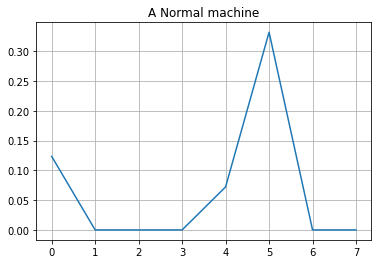

In [ ]:
plt.grid()
plt.plot(np.arange(8), normal_train_data[0])
plt.title("A Normal machine")
plt.show()

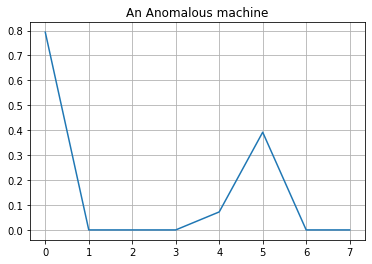

In [ ]:
plt.grid()
plt.plot(np.arange(8), anomalous_train_data[0])
plt.title("An Anomalous machine")
plt.show()


In [ ]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Dense(8, activation="relu"),
          layers.Dense(4, activation="relu"),
          layers.Dense(2, activation="relu")])

        self.decoder = tf.keras.Sequential([
          layers.Dense(2, activation="relu"),
          layers.Dense(4, activation="relu"),
          layers.Dense(8, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer=keras.optimizers.Adam(1e-2), loss='mae')

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=100,
          batch_size=512,
          validation_data=(normal_test_data, normal_test_data),
          callbacks=[early_stopping, reduce_lr_on_plateau],
          shuffle=True)

Epoch 1/100
183/183 [==============================] - 1s 3ms/step - loss: 0.0238 - val_loss: 0.0249 - lr: 0.0100
Epoch 2/100
183/183 [==============================] - 0s 3ms/step - loss: 0.0235 - val_loss: 0.0236 - lr: 0.0100
Epoch 3/100
183/183 [==============================] - 0s 3ms/step - loss: 0.0233 - val_loss: 0.0238 - lr: 0.0100
Epoch 4/100
183/183 [==============================] - 0s 3ms/step - loss: 0.0235 - val_loss: 0.0233 - lr: 0.0100
Epoch 5/100
183/183 [==============================] - 0s 3ms/step - loss: 0.0232 - val_loss: 0.0234 - lr: 0.0100
Epoch 6/100
183/183 [==============================] - 0s 3ms/step - loss: 0.0232 - val_loss: 0.0234 - lr: 0.0100
Epoch 7/100
183/183 [==============================] - 0s 3ms/step - loss: 0.0233 - val_loss: 0.0234 - lr: 0.0100
Epoch 8/100
183/183 [==============================] - 0s 3ms/step - loss: 0.0232 - val_loss: 0.0233 - lr: 0.0100
Epoch 9/100
183/183 [==============================] - 0s 3ms/step - loss: 0.0231 - val_

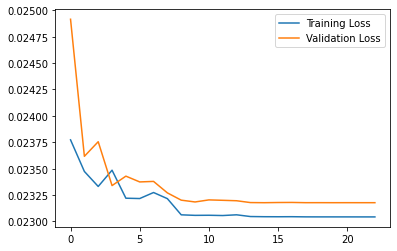

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()


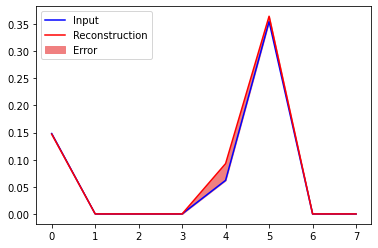

In [ ]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

sample = 1
plt.plot(normal_test_data[sample],'b')
plt.plot(decoded_imgs[sample],'r')
plt.fill_between(np.arange(8), decoded_imgs[sample], normal_test_data[sample], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


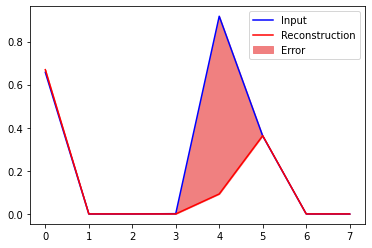

In [ ]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

sample = 1
plt.plot(anomalous_test_data[sample],'b')
plt.plot(decoded_imgs[sample],'r')
plt.fill_between(np.arange(8), decoded_imgs[sample], anomalous_test_data[sample], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


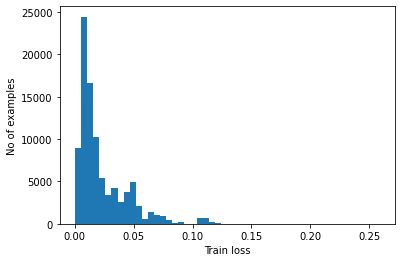

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()


In [ ]:
threshold = np.mean(train_loss) + 5*np.std(train_loss)
# threshold = 0.15
print("Threshold: ", threshold)


Threshold:  0.13331092335283756


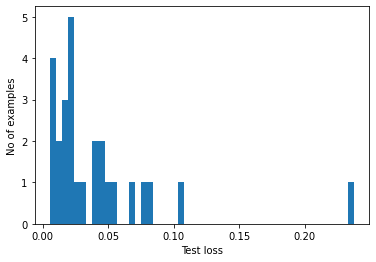

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()


In [ ]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return loss > threshold

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, preds)))
    print("Precision = {}".format(precision_score(labels, preds)))
    print("Recall = {}".format(recall_score(labels, preds)))


In [ ]:
preds = predict(autoencoder, test_data, threshold=0.1)
print_stats(preds, test_labels)

Accuracy = 0.9777663539390824
Precision = 0.0029895366218236174
Recall = 0.07407407407407407


In [ ]:
evaluate(test_labels, preds)

Confusion Matrix: 
[[30430   667]
 [   25     2]]


Classification Report:
              precision    recall  f1-score   support

       False     0.9992    0.9786    0.9888     31097
        True     0.0030    0.0741    0.0057        27

    accuracy                         0.9778     31124
   macro avg     0.5011    0.5263    0.4973     31124
weighted avg     0.9983    0.9778    0.9879     31124



## Isolation Forest

In [ ]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = prep_data(df)

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,122386752.674,159.485,9.940,1.741,14.223,260172.858,0.293,12.452
std,70459597.488,2179.658,185.747,22.909,15.943,99151.010,7.437,191.426
min,0.000,0.000,0.000,0.000,1.000,8.000,0.000,0.000
25%,61276754.000,0.000,0.000,0.000,8.000,221452.000,0.000,0.000
50%,122795744.000,0.000,0.000,0.000,10.000,249799.500,0.000,0.000
75%,183308370.000,0.000,0.000,0.000,12.000,310266.000,0.000,0.000
max,244140480.000,64968.000,24929.000,1666.000,98.000,689161.000,832.000,18701.000


,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-1.737,-0.073,-0.054,-0.076,-0.829,-2.624,-0.039,-0.065
25%,-0.867,-0.073,-0.054,-0.076,-0.390,-0.391,-0.039,-0.065
50%,0.006,-0.073,-0.054,-0.076,-0.265,-0.105,-0.039,-0.065
75%,0.865,-0.073,-0.054,-0.076,-0.139,0.505,-0.039,-0.065
max,1.728,29.733,134.156,72.648,5.255,4.327,111.835,97.629


Value counts: 
y_test
0    31097
1       27
Name: failure, dtype: int64
y_train
0    93291
1       79
Name: failure, dtype: int64


In [ ]:
y_train_orig = y_train_orig.astype(bool)

In [ ]:
IsolationForest?

In [ ]:
from sklearn.ensemble import IsolationForest

# X = X_train_orig[~y_train_orig]
X = X_train_orig
print(X.shape)
clf = IsolationForest(random_state= 0,
                      n_estimators = 100,
                      contamination = 5e-3,
                      max_features = 0.75,
                      warm_start=True,
                      verbose = True).fit(X)
y_pred = clf.predict(X_test_orig)

(93370, 8)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


In [ ]:
y_pred = np.where(y_pred == -1, 1, 0)

In [ ]:
evaluate(y_test_orig, y_pred)

Confusion Matrix: 
[[30929   168]
 [   22     5]]


Classification Report:
              precision    recall  f1-score   support

           0     0.9993    0.9946    0.9969     31097
           1     0.0289    0.1852    0.0500        27

    accuracy                         0.9939     31124
   macro avg     0.5141    0.5899    0.5235     31124
weighted avg     0.9984    0.9939    0.9961     31124



## Results

### Balanced Random Forest Results : Resampled data

Legitimate Transactions Detected (True Negatives):  31032
Legitimate Transactions Incorrectly Detected (False Positives):  3
Fraudulent Transactions Missed (False Negatives):  25
Fraudulent Transactions Detected (True Positives):  31134
Total Fraudulent Transactions:  31159
Confusion Matrix: 
[[31032     3]
 [   25 31134]]


Classification Report:
              precision    recall  f1-score   support

           0     0.9992    0.9999    0.9995     31035
           1     0.9999    0.9992    0.9996     31159

    accuracy                         0.9995     62194
   macro avg     0.9995    0.9996    0.9995     62194
weighted avg     0.9996    0.9995    0.9995     62194



,0,1,2,3,4,5,6,7
tns,0.002,0.002,-0.000,0.001,-0.002,0.003,-0.002,-0.003
fps,0.308,10.056,-0.054,11.084,-0.307,-1.183,11.794,-0.058
fns,0.179,1.589,-0.038,1.366,0.234,-0.299,1.682,0.188
tps,0.275,3.630,-0.051,3.166,0.071,-0.158,14.672,0.147


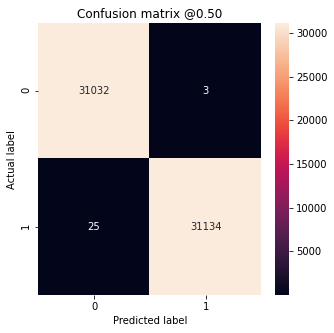

In [ ]:
plot_cm(y_test_resampled, y_pred_bfr)
evaluate(y_test_resampled, y_pred_bfr)
detailed_metrics(y_test_resampled, y_pred_bfr, pd.DataFrame(X_test_resampled))

### Balanced Random Forest Results : Original Test data

Legitimate Transactions Detected (True Negatives):  31097
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  8
Fraudulent Transactions Detected (True Positives):  19
Total Fraudulent Transactions:  27
Confusion Matrix: 
[[31097     0]
 [    8    19]]


Classification Report:
              precision    recall  f1-score   support

           0     0.9997    1.0000    0.9999     31097
           1     1.0000    0.7037    0.8261        27

    accuracy                         0.9997     31124
   macro avg     0.9999    0.8519    0.9130     31124
weighted avg     0.9997    0.9997    0.9997     31124



,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
tns,-0.006,0.003,-0.007,-0.003,-0.009,0.002,-0.003,0.000
fps,nan,nan,nan,nan,nan,nan,nan,nan
fns,0.129,0.197,-0.006,0.388,0.347,-0.387,0.633,0.696
tps,-0.044,2.369,-0.050,3.570,-0.205,-0.003,5.622,-0.045


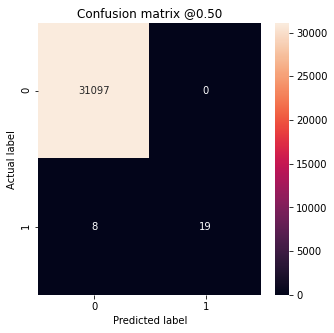

In [ ]:
plot_cm(y_test_orig, y_pred_orig_bfr)
evaluate(y_test_orig, y_pred_orig_bfr)
detailed_metrics(y_test_orig, y_pred_orig_bfr, x_test_orig)

### Feature importances plot

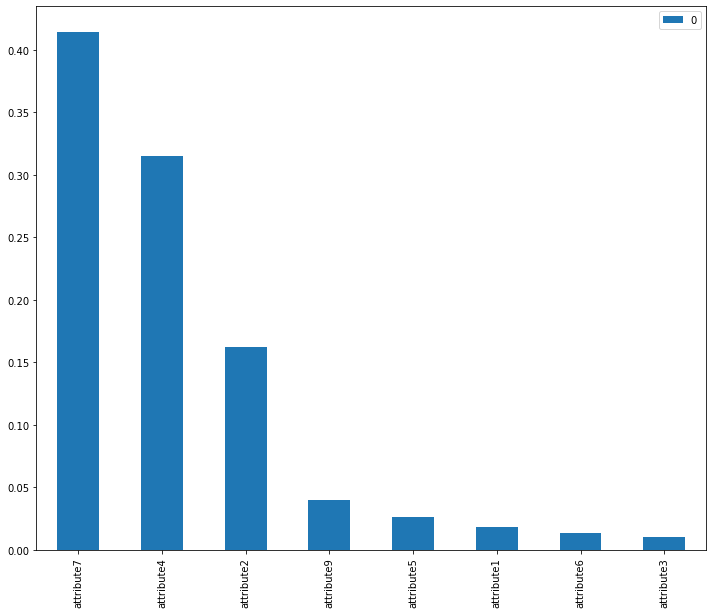

In [ ]:
# features = pd.DataFrame(columns=attr_cols)
features = pd.DataFrame(brf.feature_importances_, index=attr_cols)
features.sort_values(by=[0], ascending=False).plot(kind='bar')

### Learnings for model selection:

When training data is available:
1. Upsampling minority class using BorderlineSMOTE combined with Balanced Random Forest Classifier gave the best results.
2. Followed by Deep Neural Networks trained on resampled data.

In case of missing training data:
1. Isolation forest did a better job compared to simple autoencoders for numeric data.
2. For matrix data, deep learning approach would still be our go to.

## References

1. Understanding SMOTE : https://rikunert.com/SMOTE_explained
2. imbalanced-learn : https://imbalanced-learn.readthedocs.io/en/stable/index.html
3. Intro to Autoencoders : https://www.tensorflow.org/tutorials/generative/autoencoder
4. Simple ways to handle class imbalances: https://wandb.ai/authors/class-imbalance/reports/Simple-Ways-to-Tackle-Class-Imbalance--VmlldzoxODA3NTk
5. Balanced Random Forest Research Paper: https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf
6. Blog for ideas exploration : https://www.jeremyjordan.me/imbalanced-data/
7. Simple upsampling / downsampling code: https://elitedatascience.com/imbalanced-classes
8. Isolation forest: https://blog.paperspace.com/anomaly-detection-isolation-forest/

## Additional Ideas

1. Cluster then split into test and train based on every cluster
2. Suggest which attribute is causing the failure prediction -
    <br>2.1. Use reconstruction error from autoencoders
    <br>2.2. Multiply feature importance_ with feature value in balanced random forest

## Rough Work

In [ ]:
datapoints = prep_data(df)

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,122386752.674,159.485,9.940,1.741,14.223,260172.858,0.293,12.452
std,70459597.488,2179.658,185.747,22.909,15.943,99151.010,7.437,191.426
min,0.000,0.000,0.000,0.000,1.000,8.000,0.000,0.000
25%,61276754.000,0.000,0.000,0.000,8.000,221452.000,0.000,0.000
50%,122795744.000,0.000,0.000,0.000,10.000,249799.500,0.000,0.000
75%,183308370.000,0.000,0.000,0.000,12.000,310266.000,0.000,0.000
max,244140480.000,64968.000,24929.000,1666.000,98.000,689161.000,832.000,18701.000


,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-1.737,-0.073,-0.054,-0.076,-0.829,-2.624,-0.039,-0.065
25%,-0.867,-0.073,-0.054,-0.076,-0.390,-0.391,-0.039,-0.065
50%,0.006,-0.073,-0.054,-0.076,-0.265,-0.105,-0.039,-0.065
75%,0.865,-0.073,-0.054,-0.076,-0.139,0.505,-0.039,-0.065
max,1.728,29.733,134.156,72.648,5.255,4.327,111.835,97.629


Value counts: 
y_test
0    31097
1       27
Name: failure, dtype: int64
y_train
0    93291
1       79
Name: failure, dtype: int64


In [ ]:
datapoints = prep_data(df, scaler=preprocessing.RobustScaler())

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,122386752.674,159.485,9.940,1.741,14.223,260172.858,0.293,12.452
std,70459597.488,2179.658,185.747,22.909,15.943,99151.010,7.437,191.426
min,0.000,0.000,0.000,0.000,1.000,8.000,0.000,0.000
25%,61276754.000,0.000,0.000,0.000,8.000,221452.000,0.000,0.000
50%,122795744.000,0.000,0.000,0.000,10.000,249799.500,0.000,0.000
75%,183308370.000,0.000,0.000,0.000,12.000,310266.000,0.000,0.000
max,244140480.000,64968.000,24929.000,1666.000,98.000,689161.000,832.000,18701.000


,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,-0.003,159.485,9.940,1.741,1.056,0.117,0.293,12.452
std,0.577,2179.658,185.747,22.909,3.986,1.116,7.437,191.426
min,-1.006,0.000,0.000,0.000,-2.250,-2.813,0.000,0.000
25%,-0.504,0.000,0.000,0.000,-0.500,-0.319,0.000,0.000
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.496,0.000,0.000,0.000,0.500,0.681,0.000,0.000
max,0.994,64968.000,24929.000,1666.000,22.000,4.947,832.000,18701.000


Value counts: 
y_test
0    31097
1       27
Name: failure, dtype: int64
y_train
0    93291
1       79
Name: failure, dtype: int64


In [ ]:
datapoints = prep_data(df, scaler=preprocessing.MinMaxScaler())

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,122386752.674,159.485,9.940,1.741,14.223,260172.858,0.293,12.452
std,70459597.488,2179.658,185.747,22.909,15.943,99151.010,7.437,191.426
min,0.000,0.000,0.000,0.000,1.000,8.000,0.000,0.000
25%,61276754.000,0.000,0.000,0.000,8.000,221452.000,0.000,0.000
50%,122795744.000,0.000,0.000,0.000,10.000,249799.500,0.000,0.000
75%,183308370.000,0.000,0.000,0.000,12.000,310266.000,0.000,0.000
max,244140480.000,64968.000,24929.000,1666.000,98.000,689161.000,832.000,18701.000


,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
count,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000,124494.000
mean,0.501,0.002,0.000,0.001,0.136,0.378,0.000,0.001
std,0.289,0.034,0.007,0.014,0.164,0.144,0.009,0.010
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.251,0.000,0.000,0.000,0.072,0.321,0.000,0.000
50%,0.503,0.000,0.000,0.000,0.093,0.362,0.000,0.000
75%,0.751,0.000,0.000,0.000,0.113,0.450,0.000,0.000
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


Value counts: 
y_test
0    31097
1       27
Name: failure, dtype: int64
y_train
0    93291
1       79
Name: failure, dtype: int64
